In [1]:
using LinearAlgebra
using Plots
using DelimitedFiles
using LightGraphs
using StatsBase
using Distributions
using GraphPlot

# Part I: Network

In [2]:
# Create a network that have 98 nodes, represents the "spaces" of a shopping mall
G = Graph(98)
# A public space connecting to all cluster and offsite
node_labels=["public Space"];

In [3]:
# node 2-7 will be restaurant cluster, each is connect to the public space
for i in 2:7
    add_edge!(G, 1, i)
end

# node 32-39 will be retail store cluster, each is connect to the public space
for i in 32:39
    add_edge!(G,1,i)
end

# node 80 will be movie theater cluster, connect to the public space
add_edge!(G,1,80)

#node 93 will be gym cluster, 
add_edge!(G,1,93)

#node 98 will be offsite from shopping mall, connect to the public space
add_edge!(G,1,98)

true

In [4]:
# for each restaurant cluster there will be edges connection to 4 different restaurants 
for i in 1:6
    for j in 1:4
        add_edge!(G, i+1, 4*i-4+j+7)
    end
end

# for each retail store cluster there will be edges connection to 5 different retail stores 
for i in 1:8
    for j in 1:5
        add_edge!(G, i+31, 5*i-5+j+39)
    end
end

# movie theater cluster will have edges to connect to 12 other show rooms
for i in 1:1
    for j in 1:12
        add_edge!(G, i+79, 12*i-12+j+80)
    end
end

# gym cluster will have edges to connect to 4 gym rooms
for i in 1:1
    for j in 1:4
        add_edge!(G, i+92, 4*i-4+j+93)
    end
end

In [5]:
#Set riskmultiplier based on the location
riskmulti=[1]
#Set the compacity of each place
compacity=[2000]
# Adding appropriate label for each nodes
for i in 2:7
    push!(node_labels,"restaurant cluster")
    push!(riskmulti, 3)
    push!(compacity, 200)
end

for i in 8:31
    push!(node_labels, "restaurant $(i-7)")
    push!(riskmulti, 3)
    push!(compacity, 120)
end

for i in 32:39
    push!(node_labels, "retail store cluster")
    push!(riskmulti, 1)
    push!(compacity, 300)
end

for i in 40:79
    push!(node_labels, "retail store $(i-39)")
    push!(riskmulti, 1)
    push!(compacity, 150)
end

push!(node_labels, "cinema cluster")
push!(riskmulti, 2)
push!(compacity, 500)
for i in 81:92
    push!(node_labels, "cinema room $(i-80)")
    push!(riskmulti, 2)
    push!(compacity, 100)
end

push!(node_labels, "gym cluster")
push!(riskmulti, 3)
push!(compacity, 200)

for i in 94:97
    push!(node_labels, "gym room $(i-93)")
    push!(riskmulti, 3)
    push!(compacity, 100)
end

push!(node_labels, "Home")
push!(riskmulti, 0)
push!(compacity, 100000);

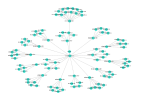

In [6]:
# Plot the network
gplot(G, nodelabel=node_labels, NODELABELSIZE=1)

# Part II: Simulation 

In [7]:
# Constructor for the agents in the simulation
mutable struct Person
    isInfected
    isEmployee
    hadMeal
    exposed
    isBackHome
    isWatchingMovie
    #An array that contains the location where the agent will be at (From 10am to 9pm)
    schedule 
    #An array that contains the true/false for each intervention(by index) that agent follows
    #1.Social distance, 2.mask, 3.temperature measurement, 
    # limit the number of people in a place(this will be controlled by the inputs for simulation)
    intervention     
    
end

In [8]:
#= 
procedure:
    generateScheduleCustomer
purpose:
    Generate a schedule for agents who are customers
parameter:
    person, Person(mutable structure); temperature, a boolean 
produces:
    (void)person, Person(mutable structure)
precodition:
    person must have all other fields set except schedule; 
    temperature must be true if the person is person.intervention[3] is true, otherwise false
postcondition: 
    person will have a schedule set, where length(person.schedule) == 12, elements in the schedule will be integers 
    from 1-98
=#
function generateScheduleCustomer(person,temperature)
    #If temperature ==true and person has been exposed to COVID19 for more than 13 days
    if temperature && person.exposed>=14
        #person will not be allowed to enter the shopping mall
        person.schedule=fill(98,12)
        return
    end
    # Set schedule back to empty
    person.schedule=[]
    # The process will repeat for 12 times
    for i in 10:21
        # If the person is still at the shopping mall
        if(!person.isBackHome)
            # If the person is not an employee
            if(!person.isEmployee)
                #If the person is already watching a movie then they will stay at same location for another hour
                if(person.isWatchingMovie)
                    push!(person.schedule,person.schedule[length(person.schedule)])
                    # After two hours, person has finish watching the movie
                    person.isWatchingMovie=false
                    continue
                end
                #Person will pick a restaurant for food if they haven't eat after 17:00
                if(i>17 && !person.hadMeal)
                    push!(person.schedule, rand(40:79))
                    person.hadMeal=true
                end
                # Choose a place to go to 
                place=rand(1:98)
                #If the person already had a meal they will not eat another meal
                if (person.hadMeal)
                        place=rand(1:98)
                        while(place >= 8 && place <= 31)
                            place=rand(1:98)
                        end
                end
                # If the place is a restaurant, person will had a meal
                if(place >= 8 && place <= 31)
                        person.hadMeal=true
                end
                # If the place is a showing room, then the person will be watching movie
                if(place >= 81 && place <= 92)
                    person.isWatchingMovie=true
                end
                # Add the location to person's schedule
                push!(person.schedule,place)
            end
        else
            # If the person is at home they will stay home
            push!(person.schedule,98)
        end
    end
end

generateScheduleCustomer (generic function with 1 method)

In [9]:
#=
procedure: 
    generateScheduleEmployee
purpose: 
    Generate a schedule for agents who are employees
parameter: 
    person, Person(mutable structure)
    temperature, a boolean
produce: 
    (void)person, Person(mutable structure)   
precondition:
    person must have all other fields set except schedule; 
    temperature must be true if the person is person.intervention[3] is true, otherwise false
postcondition: 
    person will have a schedule set, where length(person.schedule) == 12, elements in the schedule will be integers 
    from 1-98, 5 elements in the schedule will be 98, most of the other elements in the schedule will be the same
    integer
=#
function generateScheduleEmployee(person,temperature)
    #If shopping mall is doing temperature measuring and person has been exposed to COVID19 for more than 13 days
    if temperature && person.exposed>=14
        #person will not be allowed to enter the shopping mall
        person.schedule=fill(98,12)
        return
    end
    # Assign work location
    workposition=rand(1:97)
    # Assign start time for work
    startingTime = rand(10:14)
    #work hour set to 0
    workhour=0
    #Set schedule to be empty
    person.schedule=[]
    
    # Before working hour, person will not be in the mall
    if(startingTime>10)
        for i in 10:startingTime-1
            push!(person.schedule, 98)
        end
    end
    # When person start working
    for i in startingTime:21
        # If they've work for 7 hours then they will go home
        if workhour == 7
            push!(person.schedule, 98)
        else
            # Each time slot have 10% chance to be the person's free time
            freetime=rand(1:10)
            if freetime==10 && !person.hadMeal
                # person will pick a resturant to eat during their free time, if they haven't had their free time
                push!(person.schedule, rand(8:31))
                person.hadMeal=true
            else
                # person will stay in their workposition during their work hour
                push!(person.schedule, workposition)
                workhour+=1
            end
        end
    end
end

generateScheduleEmployee (generic function with 1 method)

In [42]:
#=
procedure: 
    generateEmployeeAndCustomer
purpose: 
    Generate e number of employee and c number of customers, with intervention based on p and intervarr
parameter: 
    e, an integer 
    c, an integer
    p, an float
    intervarr, an array
produce: 
    res, an array of Person, where the first e number of elements are "employee" and the rest are "customers"
    0<p<1; length(intervarr)==3
preconditions:
    length(res)== e+c; length of interventions for each elements in result is equal to length(intervarr); 
    if an element is false in the intervarr, then at the same index in the interventions for each elements 
    in result is also false
=#
function generateEmployeeAndCustomer(e,c,p,intervarr)
    #initialze res to be an array
    res=[] 
    for i in 1:e
        #each employee have 0.05% chance of already been infected by COVID-19
        isInfected = rand(1:10000)<6
        #if they are already indected then they've exposed to either 3-15 days, otherwise 
        #they've not been exposed and expose will be set to 1
        expose = isInfected ? rand(3:20) : 1
        #creating the employee, and set interventions based on intervarr, if intervarr[i] is false, then the corresponding 
        #index will also be false, otherwise, the corresponding index will be true only if p is greater than the random 
        #float generated 
        employee=Person(isInfected,true,false,expose,false,false,[],map((x)-> x ? p > rand(Float64) : false,intervarr))
        #add the employee into the result
        push!(res,employee)
    end
    for i in 1:c
        #each customer have 0.05% chance of already been infected by COVID-19
        isInfected = rand(1:10000)<6
        #if they are already indected then they've exposed to either 3-15 days, otherwise 
        #they've not been exposed and expose will be set to 1
        expose = isInfected ? rand(3:20) : 1
        #creating the customer, and set interventions based on intervarr, if intervarr[i] is false, then the corresponding 
        #index will also be false, otherwise, the corresponding index will be true only if p is greater than the random 
        #float generated 
        customer=Person(isInfected,false,false,expose,false,false,[],map((x)-> x ? p > rand(Float64) : false,intervarr))
        #add the customer into the result
        push!(res,customer)
    end
    return res
end

generateEmployeeAndCustomer (generic function with 1 method)

In [11]:
#=
procedure:
    generateSchedule
purpose: 
    Generating schedule for agents
parameter: 
    people, an array of Person
    startpoint, an integer
    endpoint, an integer
    temperature, an boolean
produce: 
    people, elements in people from index startpoint to endpoint have new schedule (void)
=#
function generateSchedule(people, startpoint, endpoint, temperature)
    #If the starting point is a employee, then from startpoint to endpoint will all be employee, 
    # otherwise all customer
    isEmployee=people[startpoint].isEmployee
    for i in startpoint:endpoint
        # If the they are all employee then generate employee schedule for them, and pass in temperature
        if isEmployee
            generateScheduleEmployee(people[i],temperature)
        else
        # Otherwise they are all customer and generate customer for them, and pass in temperature
            generateScheduleCustomer(people[i],temperature)
        end
    end
end

generateSchedule (generic function with 1 method)

In [12]:
#=
procedure:
    location!
purpose: 
    Generate a 2D array, where it contains the number of people at a location during a specific time of the day
parameter: 
    place, an 2D array
    people, an array of Person
    iteration, an integer
produce: 
    place, an 2D array
=#
function location!(places,people, iteration)
    i = 1
    #Reset each array in the place to be empty
    for p in places
        places[i]=[]
        i+=1
    end
    i=1
    #For each Person in people 
    for p in people
        # Assign each person with an integer(based on its index in people) and place it into the 2D array
        push!(places[p.schedule[iteration]], i)
        i+=1
    end
end

location! (generic function with 1 method)

In [13]:
#=
procedure:
    hasCovid
purpose: 
    Find the number of infected people, who is able to infect others, at each location
parameter: 
    people, an array of Person
    place, a 2D array of integer
produce: 
    sum, an integer
=#
function hasCovid(people, place)
    # Set sum to be zero
    sum=0
    # For each integer(the index of the person) in place 
    for p in place
        # Get the corresponding person, and increment sum if the person is infected and wheter if they 
        #has been infected for more than 2 days (onces they are infected for more than 2 day, then they can 
        #infect others)
        if people[p].isInfected==true && people[p].exposed>2
            sum+=1
        end
    end
    return sum
end

hasCovid (generic function with 1 method)

In [14]:
#=
procedure:
    generatePeople
purpose: 
    Generate the array of person with all fields filled
parameter: 
    employeeNum, an integer
    customerNum, an integer
    p, an float
    arr, an array
produce: 
    people, an array
=#
function generatePeople(employeeNum,customerNum,p,arr)
    #Generating employeeNum number of employees and customerNum number of customers, with p and arr
    people=generateEmployeeAndCustomer(employeeNum,customerNum,p, arr)
    #Generate/update the schedule of first employeeNum number of person
    generateSchedule(people,1,employeeNum,arr[3])
    #GGenerate/update the schedule of customerNum number of person, after employeeNum
    generateSchedule(people,employeeNum+1,employeeNum+customerNum,arr[3])
    return people
end

generatePeople (generic function with 1 method)

In [43]:
#=
procedure:
    simulate
purpose:
    simulate the agent-base modeling using the parameters to see the daily infection number and total infection 
    number over 30 days
parameters:
    employeeNum, an integer
    customerNum, an integer
    prob, an float
    interventions, an array of boolean
produce:
    result, an 2D array
precondition:
    0<prob<1; length(interventions)==3;
postcondition:
    length(result[1])==30; length(result[2])==30
=#
function simulate(employeeNum,customerNum,prob,interventions)
    #Generate people with all fields filled 
    people=generatePeople(employeeNum,customerNum,prob,interventions)
    #Initialized totalInfection to as an array
    totalInfection = []
    #Set total to be 0
    total = 0
    #totalPeople = employeeNum
    #Initialized totalInfection to as an array
    daily=[]
    #For each of the 30 days
    for x in 1:30
        #Set dailyInfected to be 0
        dailyInfected = 0
        #For each of the 12 hours
        for i in 1:12
            #find where each person is located at time i
            location!(places,people,i)
            #Set v (vertex) to be 0
            vertex = 0
            #for each place array in places
            for place in places
                #Increament vertex number, which correspond to which place array in the places
                vertex+=1
                #Get the number of infected people at place
                infect = hasCovid(people, place)
                #If facemask intervention is asked
                if interventions[1] && interventions[2]
                    #Get number of infected people who are wearing facemask
                    numOfInfecPeoWearingMask=length(filter((p)->people[p].isInfected && people[p].exposed>2 && people[p].intervention[2], place))
                    #Get the infection probabilities
                    rate = riskmulti[vertex]*0.75*1.25*((infect-numOfInfecPeoWearingMask)+0.5*numOfInfecPeoWearingMask)/compacity[vertex]
                    #For each person at the place
                    for p in place
                        #Check whether one follows social distancing
                        r = people[p].intervention[1] ? 0.2*rate : rate
                        #If they are wearing facemask, then they will use the previous infection probabilities, otherwise they will be 1.333 more
                        #likely to be infected 
                        people[p].isInfected = people[p].isInfected || (people[p].intervention[2] ? rand(Float64)<r : 0.75*rand(Float64)<r) 
                    end
                elseif interventions[2]
                    #Get number of infected people who are wearing facemask
                    numOfInfecPeoWearingMask=length(filter((p)->people[p].isInfected && people[p].exposed>2 && people[p].intervention[2], place))
                    #Get the infection probabilities
                    rate = riskmulti[vertex]*0.75*1.25*((infect-numOfInfecPeoWearingMask)+0.5*numOfInfecPeoWearingMask)/compacity[vertex]
                    #For each person at the place
                    for p in place
                        #If they are wearing facemask, then they will use the previous infection probabilities, otherwise they will be 1.333 more
                        #likely to be infected 
                        people[p].isInfected = people[p].isInfected || (people[p].intervention[2] ? rand(Float64)<rate : 0.75*rand(Float64)<rate) 
                    end
                elseif interventions[1]
                    #Otherwise infection rate are not directly effected by the intervention
                    rate = riskmulti[vertex]*1.25*infect/compacity[vertex]
                    #For each person in place
                    for p in place
                        #Check whether one follows social distancing
                        r = people[p].intervention[1] ? 0.2*rate : rate
                        #If the person is not already infected, then the previous rate are used to determine if the
                        #person is infected or not
                        people[p].isInfected = people[p].isInfected || rand(Float64)<r
                    end
                else
                    #Otherwise infection rate are not directly effected by the intervention
                    rate = riskmulti[vertex]*1.25*infect/compacity[vertex]
                    #For each person in place
                    for p in place
                        #If the person is not already infected, then the previous rate are used to determine if the
                        #person is infected or not
                        people[p].isInfected = people[p].isInfected || rand(Float64)<rate
                    end
                end
            end
        end
        #For each of the employee
        for i in 1:employeeNum
            #If they are infected
            if people[i].isInfected
                #If it's the first day of the simulation and employee is already infected
                if x==1 && people[i].exposed !=1
                    #Increment the daily infected number
                    dailyInfected+=1
                end
                #increment their day of exposed
                people[i].exposed +=1
                #If it's after the first day, and employee is infected
                if people[i].exposed==2
                    #Increment the daily infected number
                    dailyInfected+=1
                end
            end
        end
        
        #totalPeople+=customerNum
        #For each of the customer
        for i in employeeNum+1:employeeNum+customerNum
            #If they are infected
            if people[i].isInfected
                #increment the daily infected number
                dailyInfected+=1
            end
            #Reset the customer before the next simulation day
            #0.05% chance of being infected
            isInfected = rand(1:10000)<6
            #Set expose to be 3-15 if infected, 1 if not infected
            expose = isInfected ? rand(3:20) : 1
            #Generate person with different fields, and set intervention
            people[i]=Person(isInfected,false,false,expose,false,false,[],map((x)-> x ? prob > rand(Float64) : false,interventions))
        end
        #Generate new schedule for all the new customers
        generateSchedule(people,employeeNum+1,employeeNum+customerNum,interventions[3])
        #Add dailyInfected to total number of infected people so far in the simulation
        total+=dailyInfected
        #append the total into totalInfection array
        push!(totalInfection, total)
        #append the dailyInfected into daily array
        push!(daily,dailyInfected)
    end
    #return the 2D array that contains both daily array and totalInfection array
    return [daily,totalInfection]
end

simulate (generic function with 1 method)

# No Interventions At All

In [16]:
#Simulation variables:
#Set employee number to be 1000
employeeNum=1000
#9000 customer in the mall each day.
customerNum=9000

#Setting up the 2D array for places
places=[]
for i in 1:98
    push!(places, [])
end
res = simulate(employeeNum,customerNum,1,[false,false,false])

2-element Array{Array{Any,1},1}:
 [131, 103, 185, 281, 631, 1045, 1512, 1977, 2687, 3282  …  6326, 6388, 6456, 6478, 6438, 6412, 6515, 6491, 6480, 6598]
 [131, 234, 419, 700, 1331, 2376, 3888, 5865, 8552, 11834  …  73139, 79527, 85983, 92461, 98899, 105311, 111826, 118317, 124797, 131395]

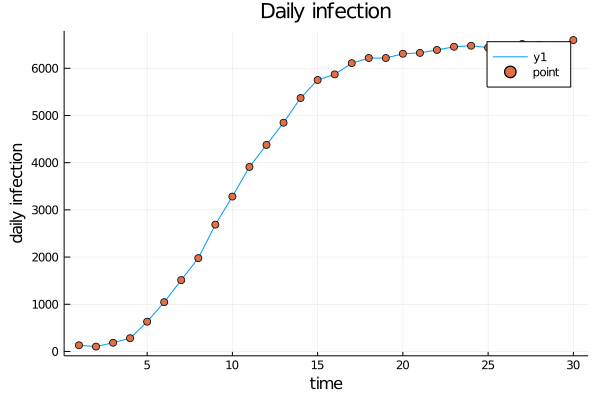

In [17]:
y = res[1]
x = 1:30
plot(x, y, title = "Daily infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("daily infection")

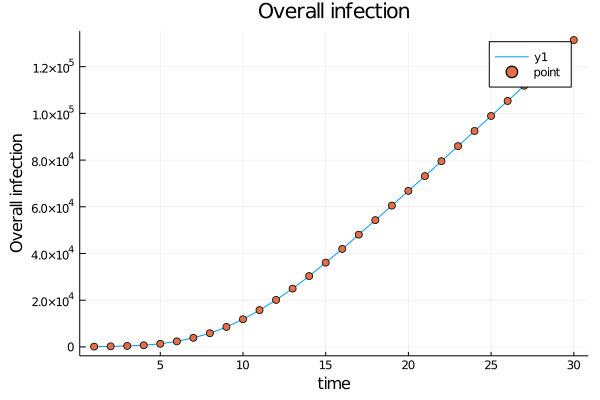

In [18]:
y = res[2]
x = 1:30
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("Overall infection")

# Social distancing

In [19]:
#Simulation variables:
#Set employee number to be 1000
employeeNum=1000
#9000 customer in the mall each day.
customerNum=9000

#Setting the 2D array for places
places=[]
for i in 1:98
    push!(places, [])
end
res = simulate(employeeNum,customerNum,1,[true,false,false])

2-element Array{Array{Any,1},1}:
 [3, 28, 20, 72, 30, 55, 67, 56, 98, 103  …  605, 572, 675, 679, 708, 710, 800, 867, 874, 1057]
 [3, 31, 51, 123, 153, 208, 275, 331, 429, 532  …  4216, 4788, 5463, 6142, 6850, 7560, 8360, 9227, 10101, 11158]

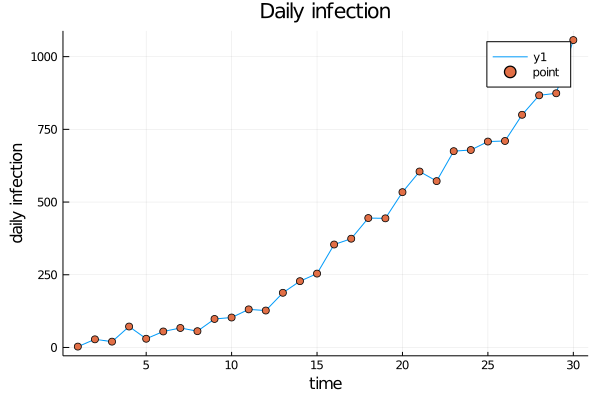

In [20]:
y = res[1]
x = 1:30
plot(x, y, title = "Daily infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("daily infection")

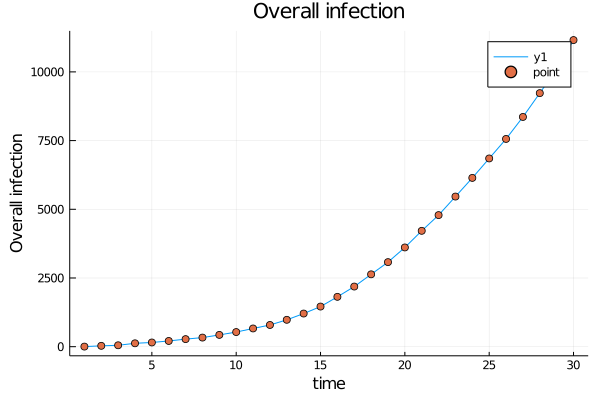

In [21]:
y = res[2]
x = 1:30
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("Overall infection")

# Facial mask

In [22]:
#Simulation variables:
#Set employee number to be 1000
employeeNum=1000
#9000 customer in the mall each day.
customerNum=9000

#Setting the 2D array for places
places=[]
for i in 1:98
    push!(places, [])
end
res = simulate(employeeNum,customerNum,1,[false,true,false])

2-element Array{Array{Any,1},1}:
 [57, 29, 60, 66, 91, 88, 106, 144, 182, 308  …  1511, 1644, 1825, 1965, 2120, 2262, 2446, 2406, 2553, 2645]
 [57, 86, 146, 212, 303, 391, 497, 641, 823, 1131  …  10676, 12320, 14145, 16110, 18230, 20492, 22938, 25344, 27897, 30542]

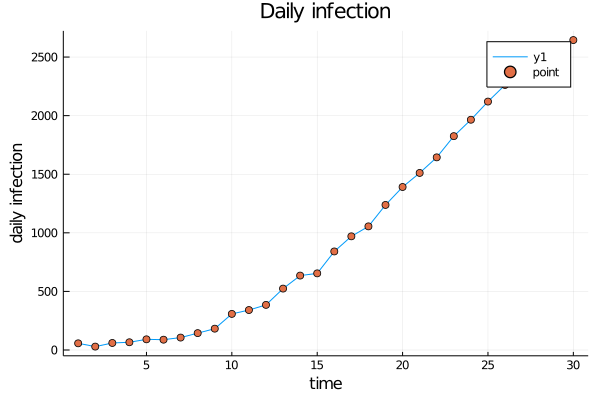

In [23]:
y = res[1]
x = 1:30
plot(x, y, title = "Daily infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("daily infection")

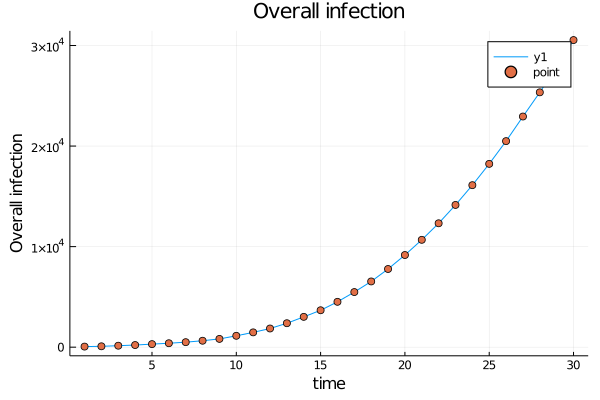

In [24]:
y = res[2]
x = 1:30
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("Overall infection")

# Temperature

In [44]:
#Simulation variables:
#Set employee number to be 1000
employeeNum=1000
#9000 customer in the mall each day.
customerNum=9000

#Setting the 2D array for places
places=[]
for i in 1:98
    push!(places, [])
end
res = simulate(employeeNum,customerNum,1,[false,false,true])

2-element Array{Array{Any,1},1}:
 [75, 47, 146, 172, 441, 658, 1157, 1472, 1935, 2413  …  6277, 6201, 6276, 6300, 6344, 6344, 6346, 6398, 6451, 6378]
 [75, 122, 268, 440, 881, 1539, 2696, 4168, 6103, 8516  …  64075, 70276, 76552, 82852, 89196, 95540, 101886, 108284, 114735, 121113]

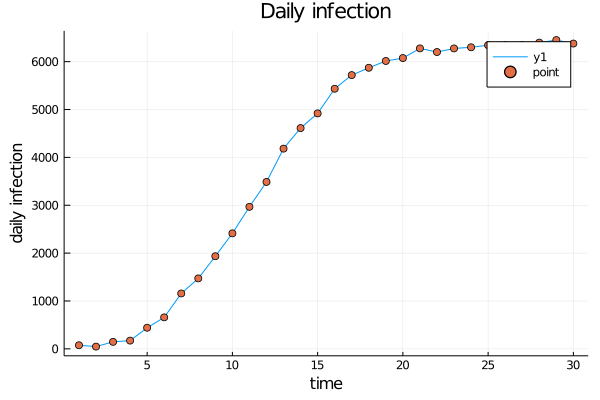

In [45]:
y = res[1]
x = 1:30
plot(x, y, title = "Daily infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("daily infection")

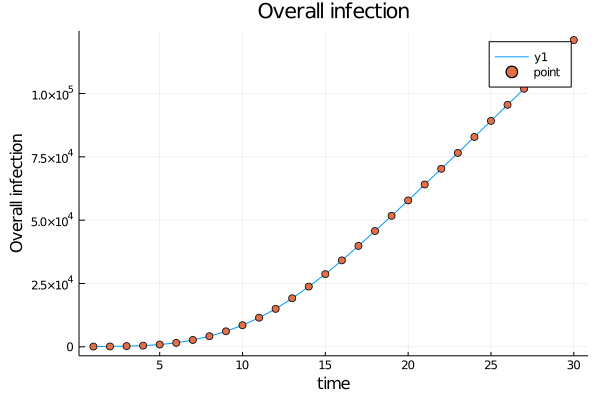

In [46]:
y = res[2]
x = 1:30
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("Overall infection")

# Limit number of people in the mall

In [28]:
#Simulation variables:
#Set employee number to be 500
employeeNum=500
#4500 customer in the mall each day.
customerNum=4500

#Setting the 2D array for places
places=[]
for i in 1:98
    push!(places, [])
end
res = simulate(employeeNum,customerNum,1,[false,false,false])

2-element Array{Array{Any,1},1}:
 [3, 15, 56, 60, 112, 171, 142, 243, 235, 440  …  1359, 1426, 1528, 1496, 1608, 1623, 1699, 1770, 1778, 1829]
 [3, 18, 74, 134, 246, 417, 559, 802, 1037, 1477  …  11716, 13142, 14670, 16166, 17774, 19397, 21096, 22866, 24644, 26473]

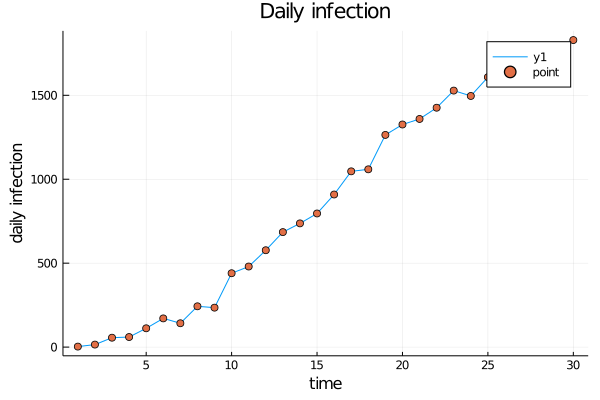

In [29]:
y = res[1]
x = 1:30
plot(x, y, title = "Daily infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("daily infection")

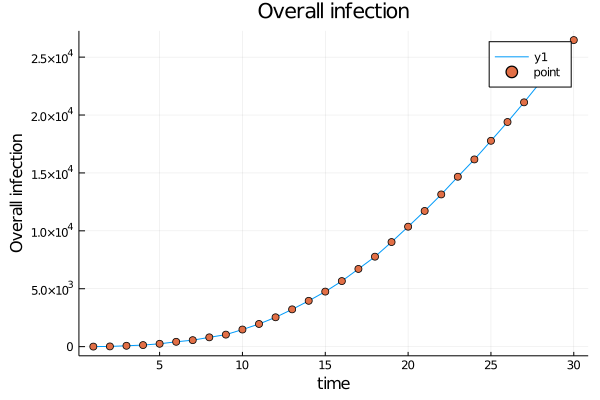

In [30]:
y = res[2]
x = 1:30
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("Overall infection")

# Follow intervention 2,3,4

In [31]:
#Simulation variables:
#Set employee number to be 500
employeeNum=500
#4500 customer in the mall each day.
customerNum=4500

#Setting the 2D array for places
places=[]
for i in 1:98
    push!(places, [])
end
res = simulate(employeeNum,customerNum,1,[false,true,true])

2-element Array{Array{Any,1},1}:
 [5, 5, 12, 17, 4, 0, 14, 20, 7, 22  …  33, 38, 60, 49, 74, 89, 88, 106, 107, 114]
 [5, 10, 22, 39, 43, 43, 57, 77, 84, 106  …  414, 452, 512, 561, 635, 724, 812, 918, 1025, 1139]

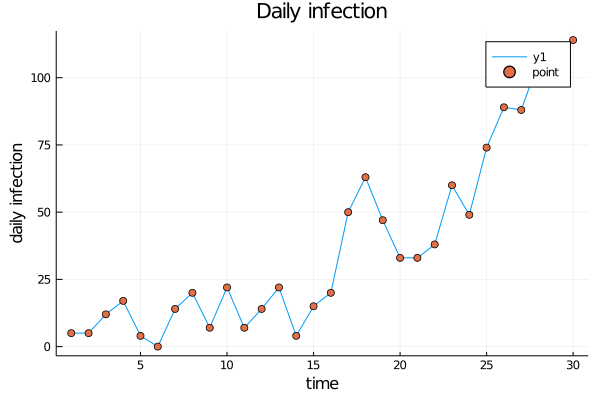

In [32]:
y = res[1]
x = 1:30
plot(x, y, title = "Daily infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("daily infection")

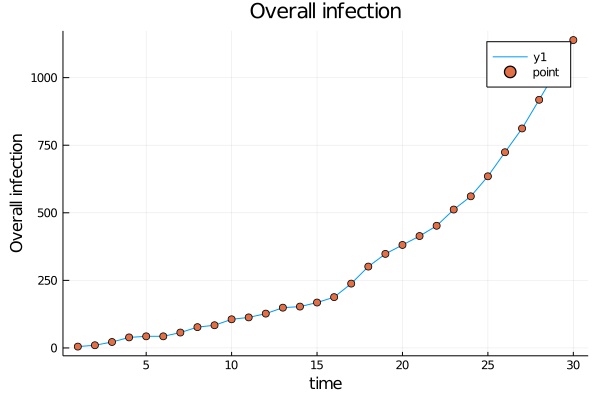

In [33]:
y = res[2]
x = 1:30
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("Overall infection")

# Percentage of people following the intervention/Infection

# -Social distancing

In [34]:
overall = []
#For probabilities from 0 to 1, intervals of 0.1
for p in 1:11
    #Simulation variables:
    # 1000 employees
    employeeNum=1000
    # 9000 customer in the mall each day.
    customerNum=9000

    #Setting the 2D array for places
    places=[]
    for i in 1:98
        push!(places, [])
    end
    #Append the total infection number after 30 days into the overall array for each probabilites
    push!(overall,simulate(employeeNum,customerNum,(p-1)/10,[true,false,false])[2][30])
end

8323


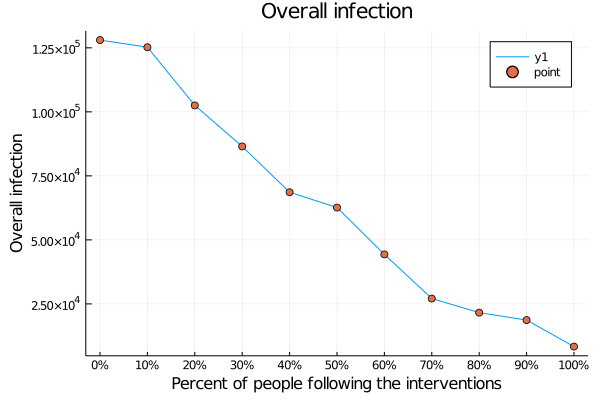

In [35]:
y = overall
x = map((i)->"$((i-1)*10)%",1:11)
println(y[length(y)])
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("Percent of people following the interventions")
ylabel!("Overall infection")

# -Facial mask

In [36]:
overall = []
#For probabilities from 0 to 1, intervals of 0.1
for p in 1:11
    #Simulation variables:
    # 1000 employees
    employeeNum=1000
    # 9000 customer in the mall each day.
    customerNum=9000

    #Setting the 2D array for places
    places=[]
    for i in 1:98
        push!(places, [])
    end
    #Append the total infection number after 30 days into the overall array for each probabilites
    push!(overall,simulate(employeeNum,customerNum,(p-1)/10,[false,true,false])[2][30])
end

31517


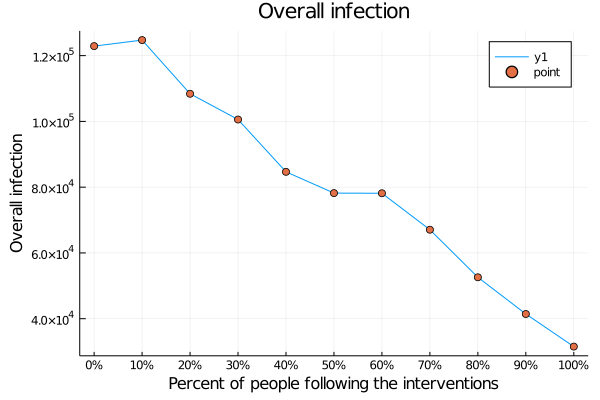

In [37]:
y = overall
x = map((i)->"$((i-1)*10)%",1:11)
println(y[length(y)])
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("Percent of people following the interventions")
ylabel!("Overall infection")

# - Following intervention 2,3,4

In [38]:
overall = []
#For probabilities from 0 to 1, intervals of 0.1
for p in 1:11
    #Simulation variables:
    # 500 employeeNum total
    employeeNum=500
    # 4500 customer in the mall each day.
    customerNum=4500

    # ? length(filter((x)->x.isInfected, people))
    #Setting the 2D array for places
    places=[]
    for i in 1:98
        push!(places, [])
    end
    #Append the total infection number after 30 days into the overall array for each probabilites
    push!(overall,simulate(employeeNum,customerNum,(p-1)/10,[false,true,true])[2][30])
end

2449


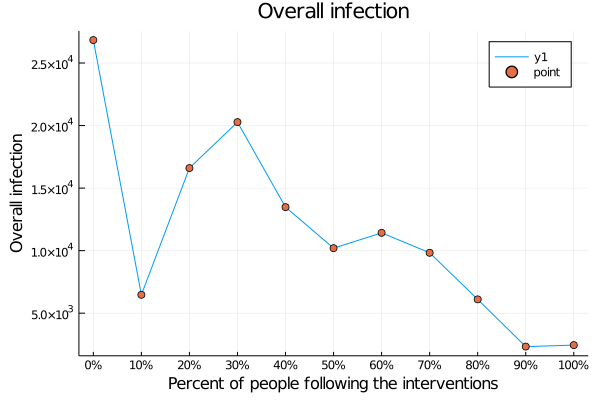

In [39]:
y = overall
x = map((i)->"$((i-1)*10)%",1:11)
println(y[length(y)])
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("Percent of people following the interventions")
ylabel!("Overall infection")

In [40]:
overall = []
#For probabilities from 0 to 1, intervals of 0.1
for p in 1:11
    #Simulation variables:
    # 500 employeeNum total
    employeeNum=500
    # 4500 customer in the mall each day.
    customerNum=4500

    # ? length(filter((x)->x.isInfected, people))
    #Setting the 2D array for places
    places=[]
    for i in 1:98
        push!(places, [])
    end
    #Append the total infection number after 30 days into the overall array for each probabilites
    push!(overall,simulate(employeeNum,customerNum,(p-1)/10,[true,true,true])[2][30])
end

175


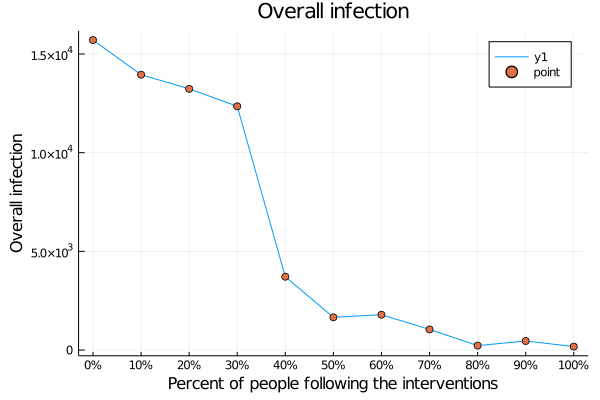

In [41]:
y = overall
x = map((i)->"$((i-1)*10)%",1:11)
println(y[length(y)])
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("Percent of people following the interventions")
ylabel!("Overall infection")